In [192]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import opendatasets as od
import nltk 
import re 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Suel.Abbasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
od.download("https://www.kaggle.com/datasets/venky73/spam-mails-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/venky73/spam-mails-dataset


100%|██████████| 1.86M/1.86M [00:00<00:00, 485MB/s]

In [167]:
df = pd.read_csv('spam-mails-dataset\spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [168]:
print(df.label.unique())
print(df.label_num.unique())
print(df.isnull().sum()  ) 

['ham' 'spam']
[0 1]
Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64


In [169]:
print(df.shape)

(5171, 4)


In [170]:
df.drop(['Unnamed: 0','label'], axis=1, inplace=True)
df.rename(columns={'label_num': 'label'}, inplace=True )

In [171]:
print(df.iloc[5,0])

Subject: ehronline web address change
this message is intended for ehronline users only .
due to a recent change to ehronline , the url ( aka " web address " ) for accessing ehronline needs to be changed on your computer . the change involves adding the letter " s " to the " http " reference in the url . the url for accessing ehronline should be : https : / / ehronline . enron . com .
this change should be made by those who have added the url as a favorite on the browser .


In [172]:
# remove punctuation and special characters
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# convert text to lowercase and remove punctuation
df['text'] = df.text.str.lower().apply(remove_punctuation)

In [173]:
# word tokenization
df['text'] = df.text.apply(word_tokenize)

In [174]:
# remove stopwords
def remove_stpwrd(text):
    stpWrd = stopwords.words('english') + ['nbsp', 'subject', 're', 'fwd', 'fw', 'from', 'to', 'cc', 'bcc','etc','ect']
    return [word for word in text if word not in stpWrd]

df['text'] = df.text.apply(remove_stpwrd)
df.text.sample()

4924    [site, sweet, teen, sex, check, download, hot,...
Name: text, dtype: object

In the context of spam and ham (non-spam) classification, both stemming and lemmatization can be helpful, but they address different needs. Stemming is faster and simpler, reducing words to their root form, while lemmatization considers the word's context and part of speech to produce a meaningful base form (lemma). For spam/ham classification, lemmatization is generally preferred if you need more accurate results and can tolerate the slightly slower processing time. However, if speed is critical and some inaccuracies are acceptable, stemming might be a better option. 

**Stemming**:
- Process: A process of reducing words to their root form by removing suffixes (e.g., "running" becomes "run").
    - Pros: Faster and simpler to implement. 
    - Cons: Can produce non-words (e.g., "studies" might become "studi"). May not always result in meaningful base forms. 

**Lemmatization**:
- Process: Reduces words to their dictionary form (lemma), considering the word's part of speech (e.g., "better" becomes "good").
    - Pros: Produces more accurate and meaningful base forms.
    - Cons: More computationally expensive and slower than stemming. 

## Spam/Ham Classification:
### Why lemmatization might be better:

- In spam detection, you want to accurately identify and group related words. Lemmatization helps ensure that variations of a word are treated as the same (e.g., "activate" and "activated" are both reduced to "activate"). This can improve the model's ability to recognize spammy phrases and patterns. 

### When stemming might be sufficient:
- If your priority is speed and you are dealing with a large dataset where the differences between stemming and lemmatization might not be significant, stemming could be a good starting point. However, if you are seeing issues with accuracy, switching to lemmatization might be beneficial

In [175]:
# lets go for lemmatization 

def lemmatize_text(text):
    lemma = WordNetLemmatizer()
    return [lemma.lemmatize(word) for word in text]

df['text'] = df.text.apply(lemmatize_text)
print(df.iloc[100,:])

text     [help, brian, talk, getting, daren, farmer, la...
label                                                    0
Name: 100, dtype: object


In [176]:
# EDA
# class distribution
print(df.label.value_counts())

label
0    3672
1    1499
Name: count, dtype: int64


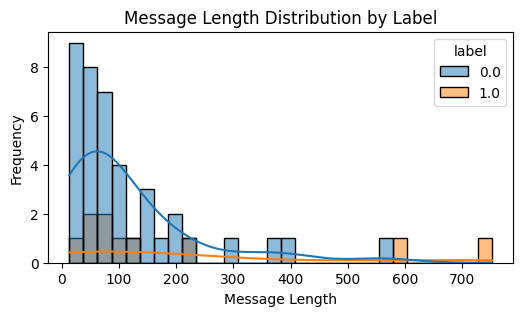

In [178]:
# message length distribution, with labels
plt.figure(figsize=(6, 3))
sns.histplot(data=df.sample(50), x=df.text.apply(len), hue='label', kde=True, bins=30)
plt.title('Message Length Distribution by Label')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

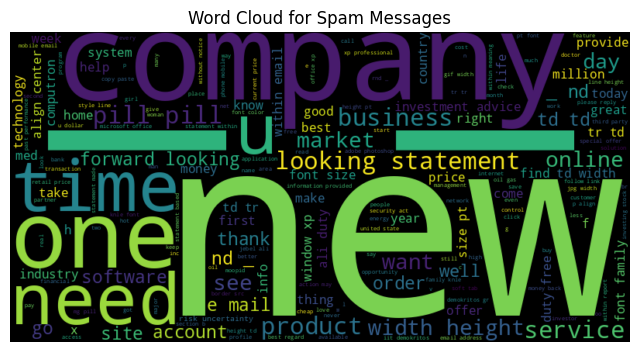

In [179]:
# word cloud for spam messages
from wordcloud import WordCloud
spam_text = ' '.join(df[df.label == 1].text.apply(lambda x: ' '.join(x)))
wordcloud = WordCloud(width=800, height=400).generate(spam_text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

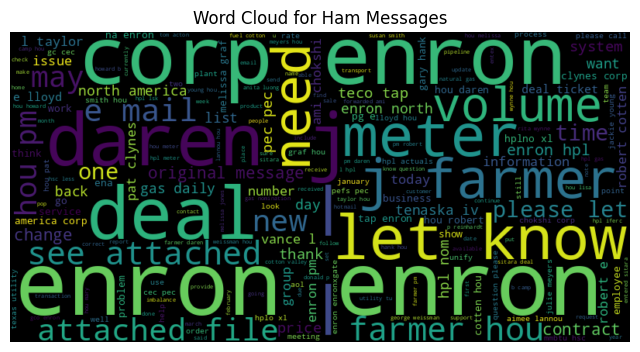

In [180]:
# word cloud for ham messages
from wordcloud import WordCloud
spam_text = ' '.join(df[df.label == 0].text.apply(lambda x: ' '.join(x)))
wordcloud = WordCloud(width=800, height=400).generate(spam_text)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

In [188]:
print(np.round(np.divide(df[df.label==0].label.value_counts() , df.shape[0])*100,2))
print(np.round(np.divide(df[df.label==1].label.value_counts() , df.shape[0])*100,2))


label
0    71.01
Name: count, dtype: float64
label
1    28.99
Name: count, dtype: float64


In [193]:
ham_df = df[df.label == 0]
spam_df = df[df.label == 1]
ham_df.sample()

,text,label
3527,"[tristar, gas, company, may, 2001, problem, tr...",0


In [199]:
# ham freq distribution 

# Tokenize the text and create a list of words
tokens = []
for text in ham_df['text']:
    tokens.extend(text)
    
ham_fdist = FreqDist(tokens).most_common(10)
ham_fdist

[('hou', 7281),
 ('enron', 6555),
 ('2000', 4308),
 ('deal', 3534),
 ('gas', 2861),
 ('com', 2717),
 ('please', 2715),
 ('meter', 2713),
 ('pm', 2325),
 ('hpl', 2318)]

In [200]:
# spam freq distribution 

# Tokenize the text and create a list of words
tokens = []
for text in spam_df['text']:
    tokens.extend(text)
    
spam_fdist = FreqDist(tokens).most_common(10)
spam_fdist

[('3', 1239),
 ('_', 1218),
 ('com', 992),
 ('http', 984),
 ('company', 918),
 ('2', 858),
 ('u', 751),
 ('1', 720),
 ('price', 710),
 ('0', 698)]

In [201]:
df.head()

,text,label
0,"[enron, methanol, meter, 988291, follow, note,...",0
1,"[hpl, nom, january, 9, 2001, see, attached, fi...",0
2,"[neon, retreat, ho, ho, ho, around, wonderful,...",0
3,"[photoshop, window, office, cheap, main, trend...",1
4,"[indian, spring, deal, book, teco, pvr, revenu...",0


In [270]:
# Count Vectorization
count_vectorizer = CountVectorizer(ngram_range=(1, 4))
X = count_vectorizer.fit_transform(df['text'].apply(lambda x: ' '.join(x)))

feature_names = count_vectorizer.get_feature_names_out()

print("Number of features:", len(feature_names))
print("First 10 features:", feature_names[:10])

Number of features: 956592
First 10 features: ['00' '00 00' '00 00 17' '00 00 17 hour' '00 00 20' '00 00 20 40'
 '00 00 20 hour' '00 00 30' '00 00 30 000' '00 00 31']


In [271]:
x = X.toarray()
y = np.array(Y)

In [272]:
print(x.shape, y.shape)

(5171, 956592) (5171,)


In [273]:
# modelling 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.3, random_state=42)

In [274]:
print(x_train.shape, x_val.shape, x_test.shape)

(3619, 956592) (1086, 956592) (466, 956592)


In [275]:
# calculate class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

Validation Accuracy: 0.9705340699815838
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       793
           1       0.91      0.99      0.95       293

    accuracy                           0.97      1086
   macro avg       0.95      0.98      0.96      1086
weighted avg       0.97      0.97      0.97      1086

F1 Score: 0.9708873568400991


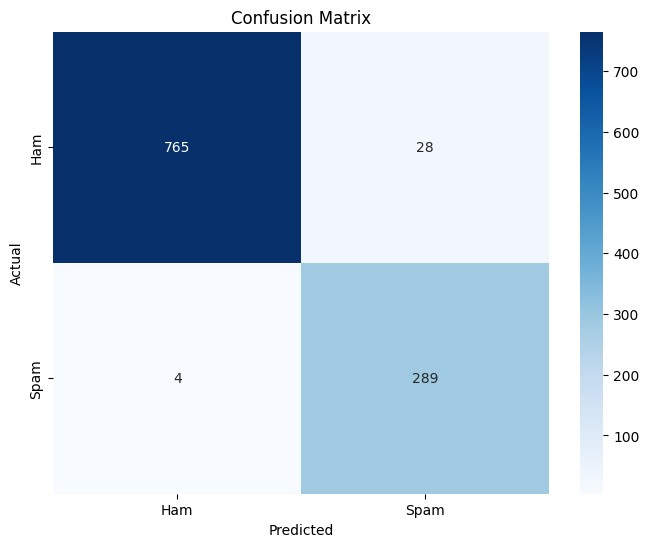

In [276]:
LR = LogisticRegression(class_weight=class_weights)
LR.fit(x_train, y_train)
y_pred = LR.predict(x_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
f1_score_test = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1_score_test)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Validation Accuracy: 0.9763948497854077
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       328
           1       0.93      1.00      0.96       138

    accuracy                           0.98       466
   macro avg       0.96      0.98      0.97       466
weighted avg       0.98      0.98      0.98       466

F1 Score: 0.9766459290646262


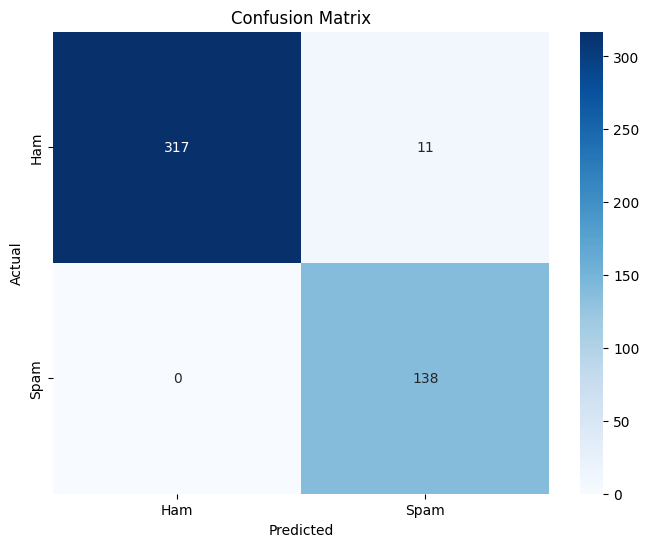

In [277]:
y_pred_test = LR.predict(x_test)
print("Validation Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
# f1 score 
f1_score_test = f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score:", f1_score_test)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Validation Accuracy: 0.9788213627992634
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       793
           1       0.96      0.97      0.96       293

    accuracy                           0.98      1086
   macro avg       0.97      0.97      0.97      1086
weighted avg       0.98      0.98      0.98      1086

F1 Score: <function f1_score at 0x000001EA122C97E0>


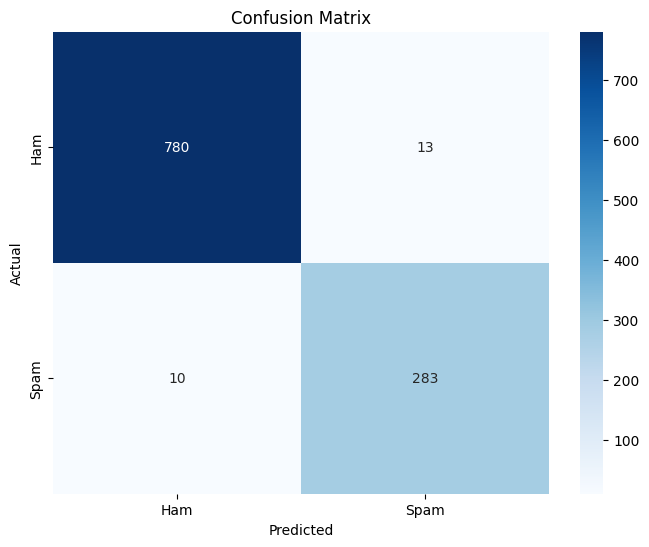

In [267]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred = NB.predict(x_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
f1_score_test = f1_score(y_val, y_pred, average='weighted')
print("F1 Score:", f1_score)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Validation Accuracy: 0.9721030042918455
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       328
           1       0.96      0.95      0.95       138

    accuracy                           0.97       466
   macro avg       0.97      0.97      0.97       466
weighted avg       0.97      0.97      0.97       466

F1 Score: 0.9720735130718081


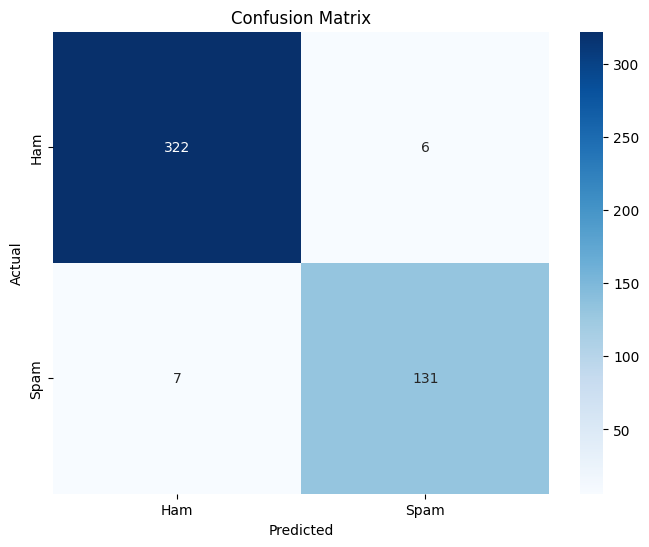

In [268]:
y_pred_test = NB.predict(x_test)
print("Validation Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))
# f1 score 
f1_score_test = f1_score(y_test, y_pred_test, average='weighted')
print("F1 Score:", f1_score_test)

# confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')   
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [278]:
# save model as joblib
import joblib
joblib.dump(LR, 'spam_classifier_lb.joblib')
joblib.dump(NB, 'spam_classifier_nb.joblib')

['spam_classifier_nb.joblib']